# UNERD

Unsupervised Name Entity Recognition Detection

- This is a library for detecting ANY entity in ANY body of text

### Imports

In [73]:
import nltk
import numpy as np
from nltk.corpus import wordnet as wn
import gensim
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('../assets/plot_styles.mplstyle')
import mobypy as mbp
from tqdm.notebook import tqdm
import warnings
import sys
sys.path.append('../library/')
from plotting import loadPalette

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/seankortschot/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/seankortschot/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/topicModelling/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [34]:
from nltk.corpus import wordnet as wn

def findAdjacentTerms(term: str = '', include_moby: bool = False):
    adjTerms = set()

    # Get synsets for the term
    synsets = wn.synsets(term)

    for synset in synsets:
        # Explore hypernyms (more general terms)
        for hypernym in synset.hypernyms():
            for hyponym in hypernym.hyponyms():
                for lemma in hyponym.lemmas():
                    adjTerms.add(lemma.name())

        # Explore hyponyms (more specific terms)
        for hyponym in synset.hyponyms():
            for lemma in hyponym.lemmas():
                adjTerms.add(lemma.name())

        # Explore synonyms (lemmas of the same synset)
        for lemma in synset.lemmas():
            adjTerms.add(lemma.name())

        # Explore meronyms (parts of the concept)
        for meronym in synset.part_meronyms():
            for lemma in meronym.lemmas():
                adjTerms.add(lemma.name())

        # Explore holonyms (the whole to which the concept belongs)
        for holonym in synset.part_holonyms():
            for lemma in holonym.lemmas():
                adjTerms.add(lemma.name())

    if include_moby:
        warnings.warn("Including Moby Thesaurus terms may take additional time.", UserWarning)
        confirmation = input("Do you want to proceed? (yes/no): ").strip().lower()
        if confirmation != 'yes':
            print("Operation cancelled by the user.")
            return []

        # Assuming mbp is defined and imported correctly
        mbp_syns = set(mbp.synonyms(term))
        adjTerms.update(mbp_syns)

    return [t.replace('_', ' ') for t in adjTerms]


In [30]:
class RecursiveDictTransformer:
    def __init__(self, initial_dict, term_generator, max_depth=1):
        """
        :param initial_dict: The original dictionary (e.g., t1).
        :param term_generator: A function that generates new terms for the given key-value pairs.
        :param max_depth: The maximum recursion depth to apply the transformation.
        """
        self.data = initial_dict
        self.term_generator = term_generator
        self.max_depth = max_depth
        self.seen_terms = []  # Set to keep track of seen terms

        def _find_parent_key(nested_dict, target_key, parent=None):
            """
            Recursively finds the parent key of a target key within a nested dictionary.
            
            :param nested_dict: The dictionary to search in.
            :param target_key: The key whose parent you are looking for.
            :param parent: The current parent key (used during recursion).
            :return: The parent key if found, otherwise None.
            """
            for key, value in nested_dict.items():
                if key == target_key:
                    return parent  # Found the target key, return the parent key
                elif isinstance(value, dict):
                    # Recursively search the nested dictionary
                    result = _find_parent_key(value, target_key, key)
                    if result:
                        return result
            return None  

    
    def _transform(self, d, current_depth, parent_key=None):
        """
        Recursively transforms the dictionary, converting lists into nested dictionaries
        based on a specified depth.
        
        :param d: The current dictionary to transform.
        :param current_depth: The current depth of recursion.
        :param parent_key: The parent key at the current level (used for similarity check).
        :return: The transformed dictionary.
        """
        if current_depth >= self.max_depth:
            return d

        transformed_dict = {}
        for key, value in d.items():
            if isinstance(value, list):
                # Convert the list into a dictionary and recurse into that dictionary
                transformed_values = {
                    v: self.term_generator(v, self.seen_terms, parent_key) for v in value
                }

                transformed_dict[key] = {
                    k: (self._transform({k: v}, current_depth + 1, k) if isinstance(v, list) else v)
                    for k, v in transformed_values.items()
                }

            elif isinstance(value, dict):
                # Recurse deeper if we find a nested dictionary
                transformed_dict[key] = self._transform(value, current_depth + 1, self._find_parent_key(d, value))
            else:
                transformed_dict[key] = value

        return transformed_dict
    
    def transform(self):
        """Transforms the initial dictionary up to the max_depth."""
        self.data = self._transform(self.data, 0)

def generate_terms(key_value_pair, seen_terms, parent_key):
    """
    Generate new terms for the key-value pair. Ensure that terms are not already in the seen set
    and are similar to the parent_key.
    :param key_value_pair: The current key-value pair.
    :param seen_terms: Set of terms that have already been generated.
    :param parent_key: The parent key to check for similarity.
    :return: A list of new terms that haven't been used yet and are similar to parent_key.
    """
    kwAdjTerms = []
    adjTerms = findAdjacentTerms(key_value_pair[0], include_moby=True)

    if key_value_pair[0] not in model:
        return []

    for adjTerm in tqdm(adjTerms, desc="Generating Terms"):
        if adjTerm not in model or adjTerm in seen_terms:
            continue

        if parent_key != None:
            if adjTerm == parent_key[0]:
                continue
        
        kwSim = model.similarity(adjTerm, key_value_pair[0])

        if parent_key != None:
            parentSim = model.similarity(adjTerm, parent_key[0])
        else:
            parentSim = 1

        totalSim = kwSim * parentSim
        
        if totalSim > .2:
            kwAdjTerms.append((adjTerm, totalSim))


    # Update the seen_terms set with the newly generated terms
    seen_terms += [k[0] for k in kwAdjTerms]
    
    return kwAdjTerms

In [31]:
# Example usage
conceptMap = {
    ('haunting',5): [(w,5) for w in ['haunting', 'devil', 'specter', 'satan', 'underworld', 'exorcist', 'priest', 'ghost', 'curse']],
    ('killer', 5): [(w,5) for w in ['killer', 'murder', 'victim', 'sadistic', 'stalker', 'crime', 'detective', 'psychopath']],
    ('isolation', 5): [(w,5) for w in ['isolation', 'house', 'abandoned', 'cabin', 'desolate', 'forest', 'alone', 'desert', 'mountain']],
    ('trauma', 5): [(w,5) for w in ['trauma', 'psychological', 'paranoia', 'mystery','disturbing','atmosphere', 'moody', 'depression','sadness','turmoil']],
    ('monster', 5): [(w,5) for w in ['monster', 'beast', 'godzilla', 'shark', 'alien', 'werewolf', 'vampire', 'spider']]
}

In [32]:
# Create a transformer with a max_depth of 3
transformer = RecursiveDictTransformer(conceptMap, generate_terms, max_depth=3)
transformer.transform()

### Construct our graph from transformer.data

In [65]:
def extract_edges(nested_dict, parent=None, edge_list=None):
    if edge_list is None:
        edge_list = []

    for node, children in nested_dict.items():
        if parent is not None:
            source = parent[0]
            target = node[0]

            if source != target:
                weight = node[1]
                edge_list.append((source, target, weight))

        if isinstance(children, dict):
            extract_edges(children, node, edge_list)
        elif isinstance(children, list):
            for child in children:
                if node[0] == child[0]:
                    continue
                edge_list.append((node[0], child[0], child[1]))

    return edge_list

In [66]:
network_edges = extract_edges(transformer.data)

G = nx.Graph()
G.add_weighted_edges_from(network_edges)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 4701
Number of edges: 4714


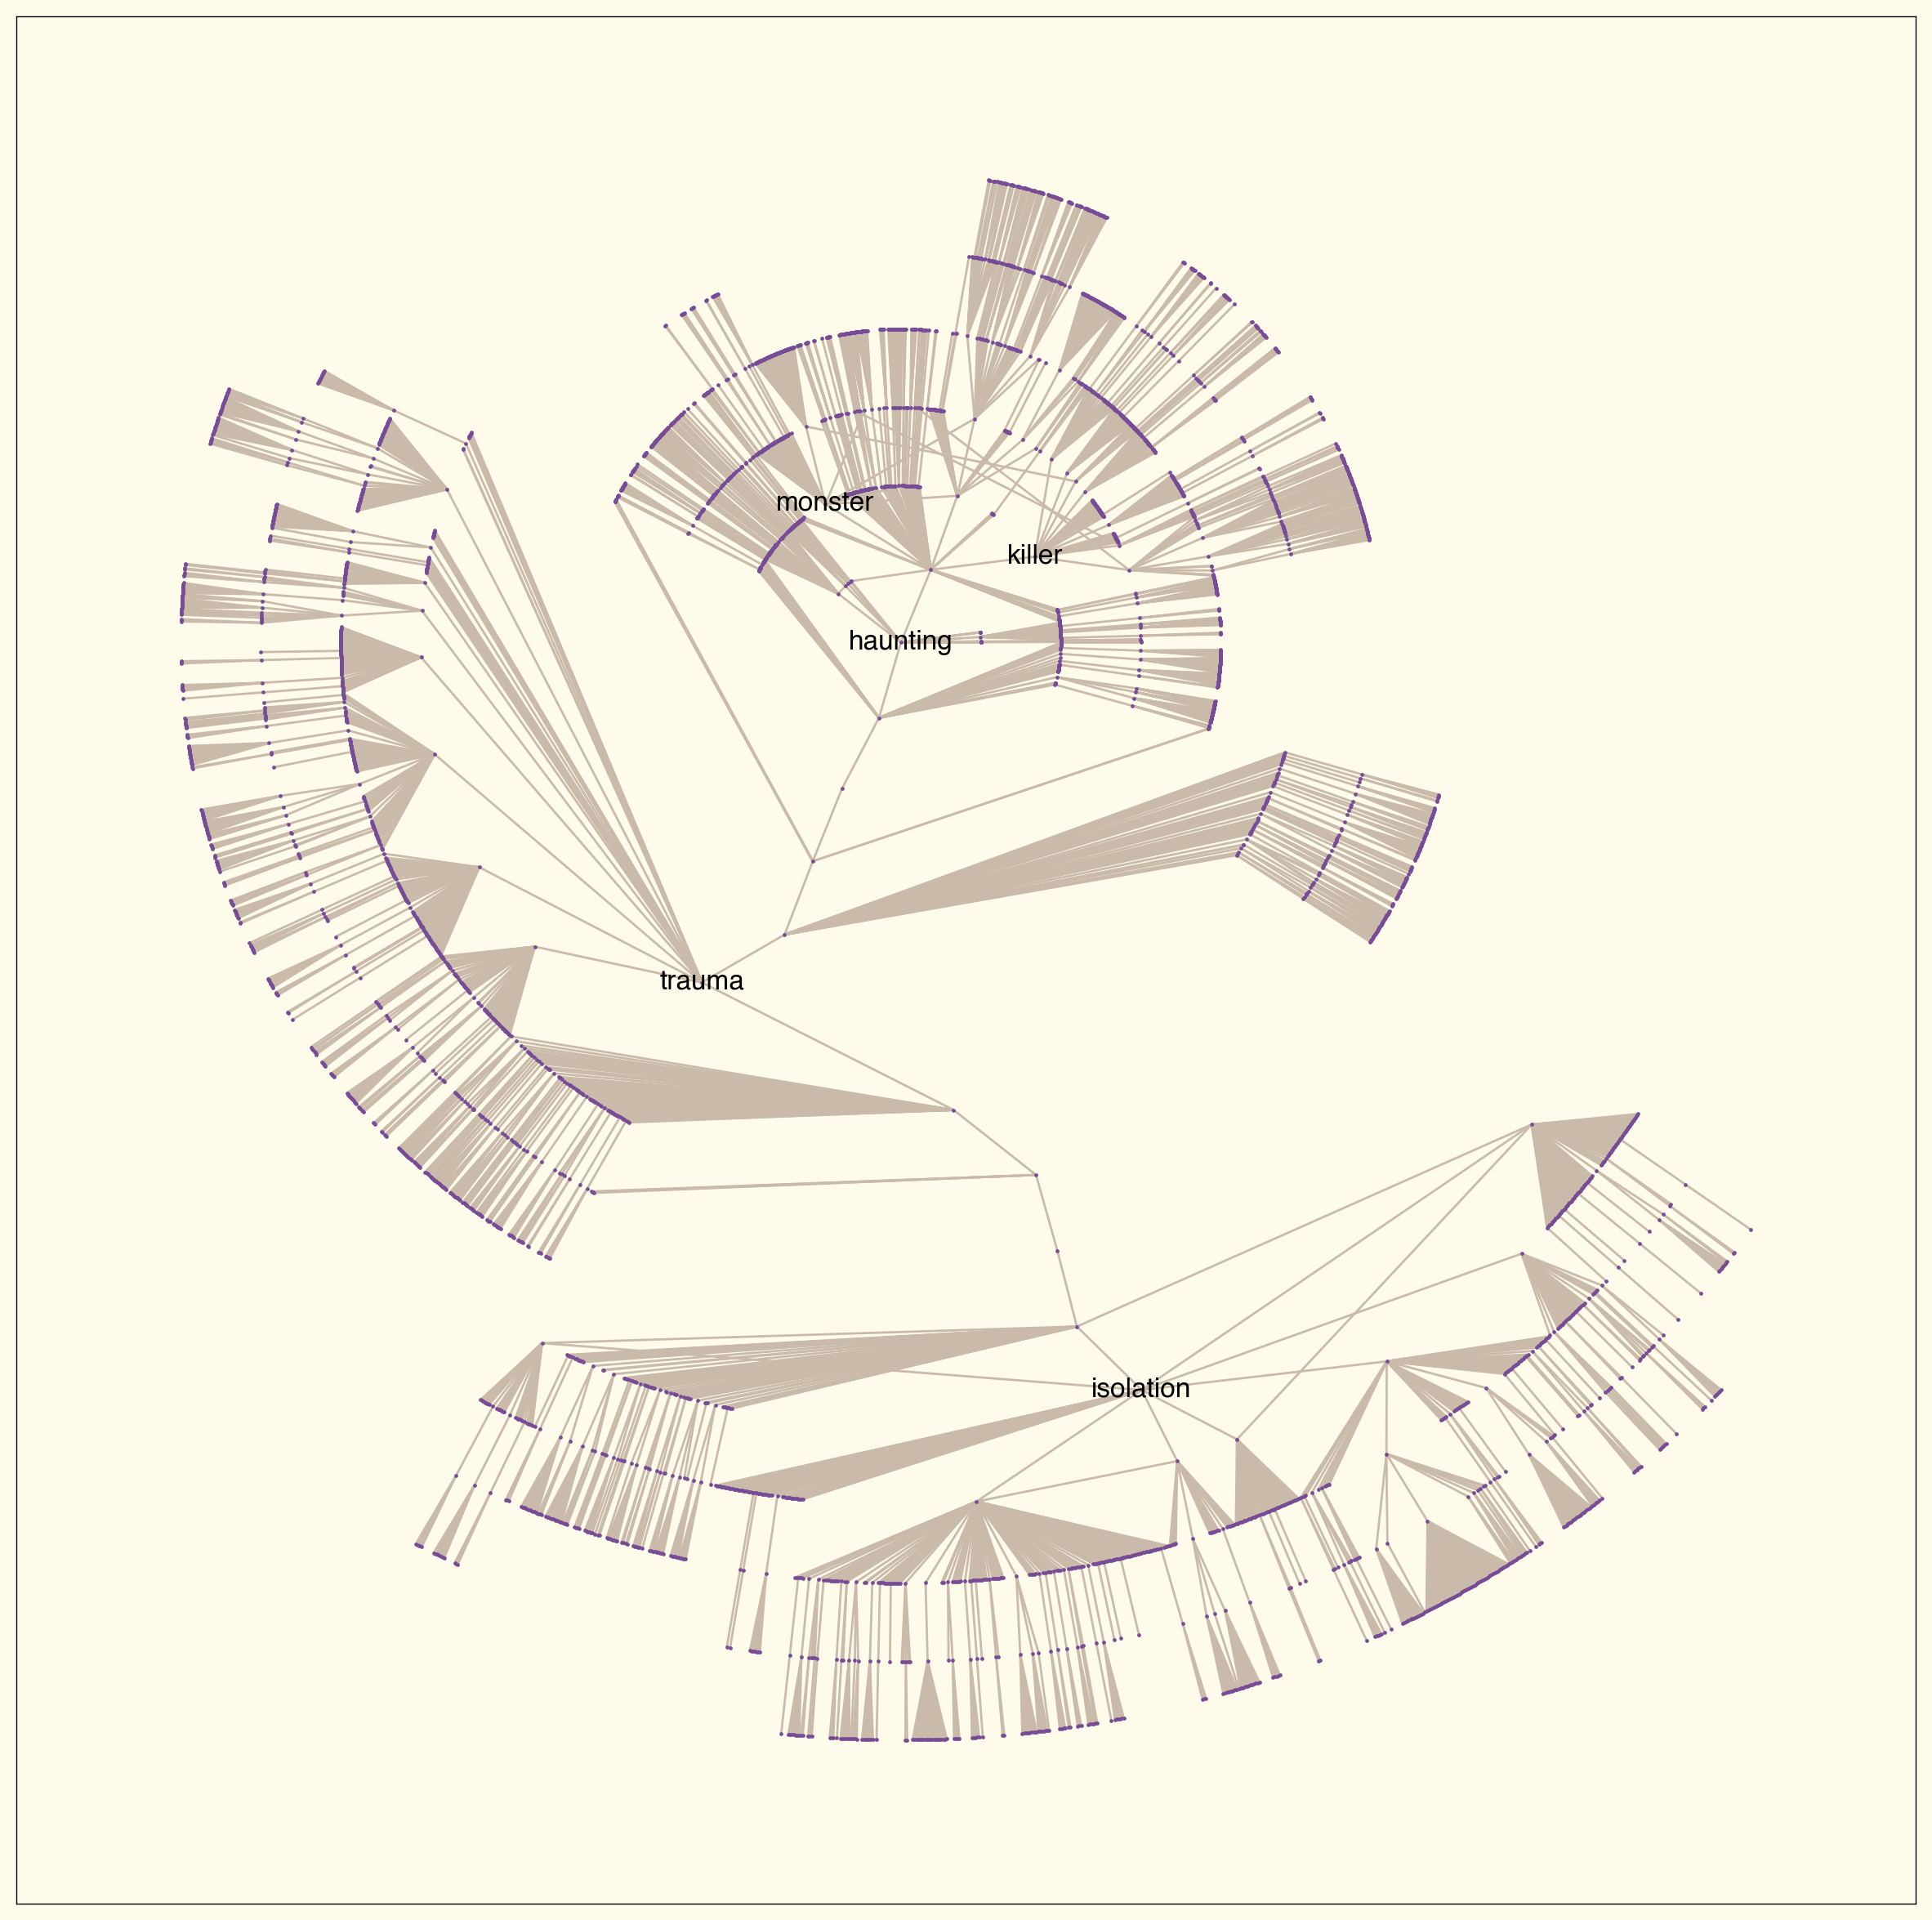

In [75]:
color_palette = loadPalette()

plt.figure(figsize=(15,15))
pos = nx.nx_agraph.graphviz_layout(G, prog='twopi', root=list(conceptMap.keys())[0][0])
nx.draw_networkx(G, pos=pos, 
                with_labels=False, node_size=0.5,
                edge_color=color_palette['canvas_dark'],
                node_color=color_palette['grape']) 

nodes_to_annotate = {}

for concept,weight in conceptMap.keys():
    nodes_to_annotate[concept] = concept

nx.draw_networkx_labels(G, pos, labels=nodes_to_annotate, font_size=12, font_color='black')


plt.show()

In [ ]:
import igraph as ig
bigGraphAsTupleList = networkEdges
g = ig.Graph.TupleList(bigGraphAsTupleList)
layout = g.layout("rt_circular") #fr (fruchterman reingold), tree, circle, rt_circular (reingold_tilford_circular)
# bbox = size of picture
ig.plot(g,layout=layout,bbox=(10000,10000),target='mygraph.png')

In [ ]:
# Define different layout options
plt.style.use("../assets/plot_styles.mplstyle")

# Visualize the graph using Kamada-Kawai layout
fig, ax = plt.subplots(figsize=(15, 10))

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=5, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')
plt.title('Kamada-Kawai Layout')

plt.tight_layout()
plt.show()